# Imports

In [18]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET


from PIL import Image
from numpy import asarray
from bs4 import BeautifulSoup as bs

from object_detection.utils import config_util, visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [19]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    data = asarray(image)
    return data


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)


# Dados Importados

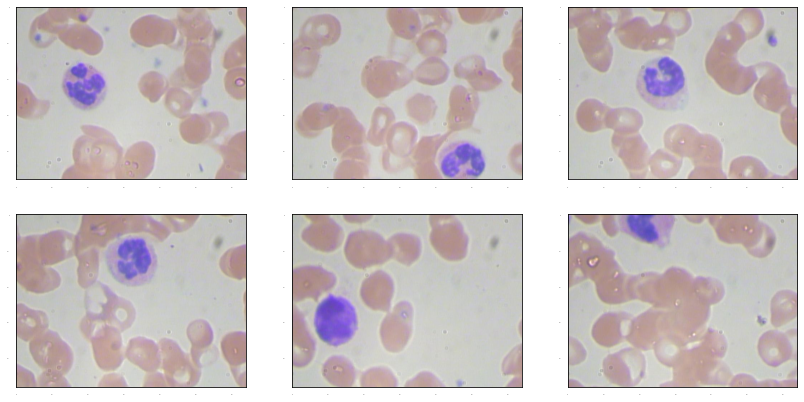

In [20]:
train_image_dir = './dataset/train/imagens/'
train_images_np = []

for i in os.listdir(train_image_dir):
    image_path = os.path.join(train_image_dir, i)
    train_images_np.append(load_image_into_numpy_array(image_path))

train_images_np_view = train_images_np[0:6]

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_images_np_view in enumerate(train_images_np_view):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_images_np_view)
plt.show()

# Ler imagens e coordenadas

In [21]:
def calcularPosicao(lista):
    xmin = lista[0]
    ymin = lista[1]
    xmax = lista[2]
    ymax = lista[3]

    larguraImagem = 640
    alturaImagem = 480

    xmin = xmin / larguraImagem
    ymin = ymin / alturaImagem
    xmax = xmax / larguraImagem
    ymax = ymax / alturaImagem

    return [ymin, xmin, ymax, xmax]

In [22]:
def encontraWBC(arquivo):
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")

        lista_objetos = bs_content.find_all("object")
        for objeto in lista_objetos:
            nome = objeto.find("name")
            xmin = objeto.find("xmin")
            ymin = objeto.find("ymin")
            xmax = objeto.find("xmax")
            ymax = objeto.find("ymax")
            
            if "WBC" in nome:
                nome = str(nome)
                xmin = str(xmin)
                ymin = str(ymin)
                xmax = str(xmax)
                ymax = str(ymax)

                # newNome = nome[nome.find(">")+1:nome.find("</name>")]
                newXmin = int(xmin[xmin.find(">")+1:xmin.find("</xmin>")])
                newYmin = int(ymin[ymin.find(">")+1:ymin.find("</ymin>")])
                newXmax = int(xmax[xmax.find(">")+1:xmax.find("</xmax>")])
                newYmax = int(ymax[ymax.find(">")+1:ymax.find("</ymax>")])

                return [newXmin, newYmin, newXmax, newYmax]
        
    return [0,0,0,0]
        
    
print(encontraWBC("dataset/train/coordenadas/BloodImage_00125.xml"))

[104, 149, 275, 302]


In [25]:
coordenadas_dir = 'dataset/train/coordenadas/'
coordenadas_info = []

for arquivo in os.listdir(coordenadas_dir):
    coordenadas_info.append(np.array([calcularPosicao(encontraWBC(coordenadas_dir + arquivo))], dtype=np.float32))

In [26]:
# gt_boxes = [
#             # np.array([[0.3104, 0.1625, 0.6291, 0.4296]], dtype=np.float32),
#             np.array([calcularPosicao([104, 149, 275, 302])], dtype=np.float32),
#             np.array([calcularPosicao([400, 370, 547, 480])], dtype=np.float32),
#             np.array([calcularPosicao([172, 126, 349, 312])], dtype=np.float32),
#             np.array([calcularPosicao([238, 53, 414, 210])], dtype=np.float32),
#             np.array([calcularPosicao([46, 212, 193, 370])], dtype=np.float32)
# ]

In [27]:
gt_boxes = coordenadas_info

# Preparando dados para treinamento

In [28]:
wbc_id = 1
num_classes = 1

category_index = {wbc_id: {'id': wbc_id, 'name': 'wbc'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Dados preparados')


Dados preparados


# Visualizando imagens com coordenadas

In [29]:
print(len(train_images_np))
print(len(gt_boxes))

255
255


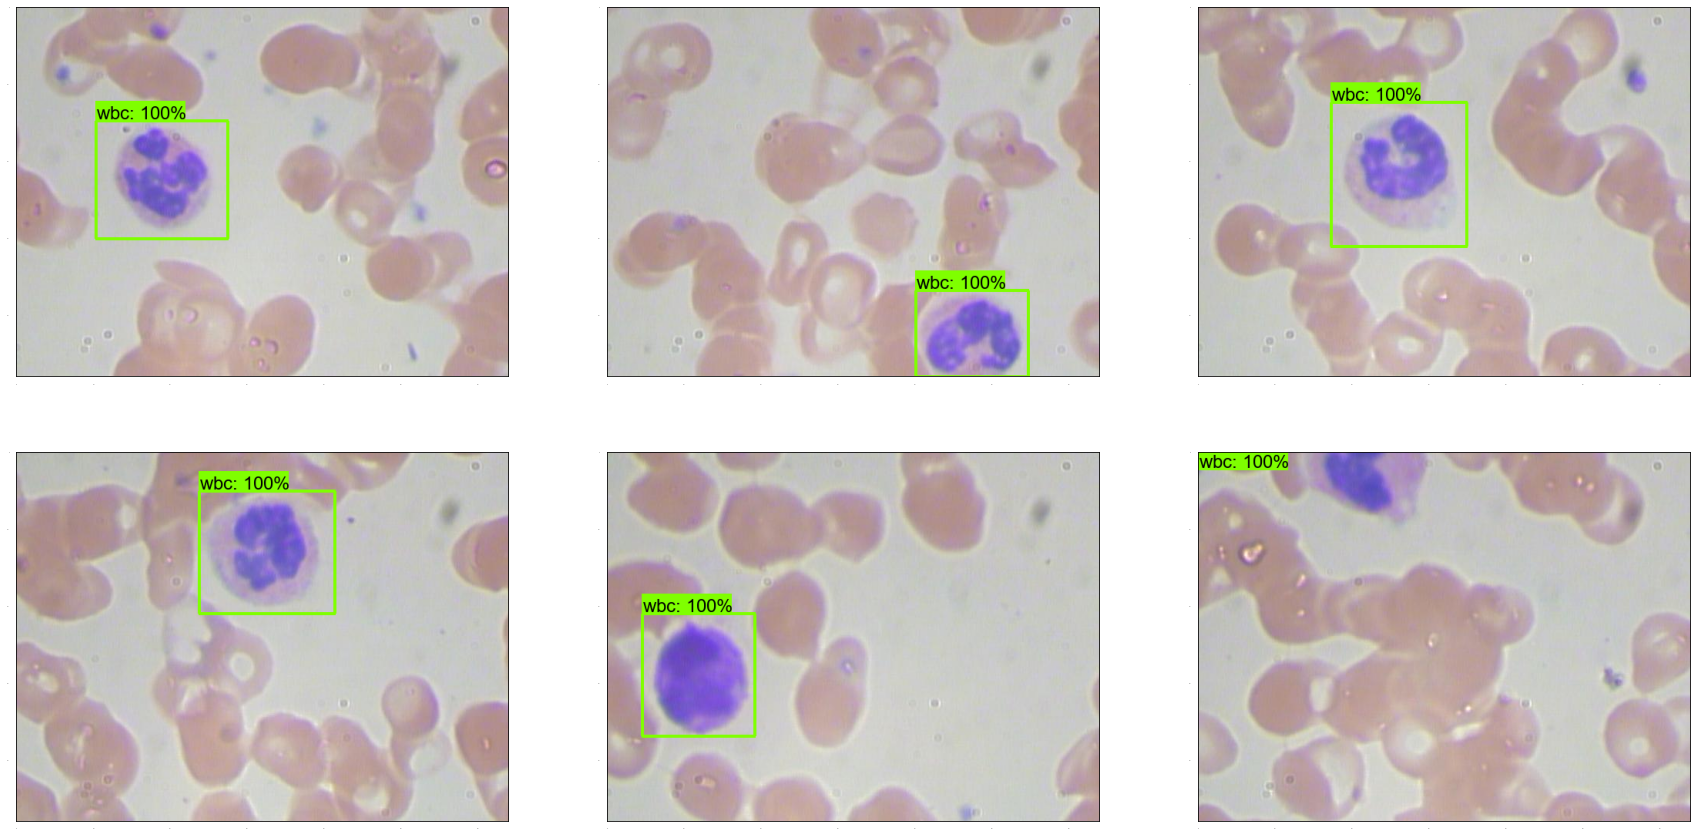

In [31]:
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Criar modelo e trabalhar com checkpoints

In [32]:
tf.keras.backend.clear_session()

print('Construindo modelo e restaurando pesos para fine-tuning...', flush=True)
num_classes = 1

pipeline_config = 'models/retinaNet50_640x640/pipeline.config'
checkpoint_path = 'models/retinaNet50_640x640/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Pesos restaurados!')

Construindo modelo e restaurando pesos para fine-tuning...
Pesos restaurados!


# Loop de treinamento personalizado

In [34]:
tf.keras.backend.set_learning_phase(True)

# Valores padrão
# batch_size = 4
# learning_rate = 0.01
# num_batches = 100

batch_size = 20
learning_rate = 0.01
num_batches = 1000

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)


def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                 for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + \
                losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn


optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Fine-tuning inicializado!', flush=True)
for idx in range(num_batches):
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('Batch ' + str(idx) + ' of ' + str(num_batches)
              + ', Loss = ' + str(total_loss.numpy()), flush=True)

print('Fine-tuning realizado!')


Fine-tuning inicializado!
Batch 0 of 1000, Loss = 1.3372186
Batch 10 of 1000, Loss = 0.5584368
Batch 20 of 1000, Loss = 0.6622758
Batch 30 of 1000, Loss = 0.397377
Batch 40 of 1000, Loss = 0.3810158
Batch 50 of 1000, Loss = 0.47847497
Batch 60 of 1000, Loss = 0.52255774
Batch 70 of 1000, Loss = 0.51675653
Batch 80 of 1000, Loss = 0.5837
Batch 90 of 1000, Loss = 0.30921572
Batch 100 of 1000, Loss = 0.29407543
Batch 110 of 1000, Loss = 0.25550544
Batch 120 of 1000, Loss = 0.37180316
Batch 130 of 1000, Loss = 0.3100028
Batch 140 of 1000, Loss = 0.27128482
Batch 150 of 1000, Loss = 0.26737025
Batch 160 of 1000, Loss = 0.26243743
Batch 170 of 1000, Loss = 0.31300288
Batch 180 of 1000, Loss = 0.4829566
Batch 190 of 1000, Loss = 0.24418151
Batch 200 of 1000, Loss = 0.2493828
Batch 210 of 1000, Loss = 0.23939654
Batch 220 of 1000, Loss = 0.26341164
Batch 230 of 1000, Loss = 0.21089043
Batch 240 of 1000, Loss = 0.23002923
Batch 250 of 1000, Loss = 0.23284084
Batch 260 of 1000, Loss = 0.2841946


# Carregar imagens para teste e aplicar no modelo

In [36]:
test_image_dir = 'dataset/test/imagens/'
test_images_np = []
for i in os.listdir(test_image_dir):
    image_path = os.path.join(test_image_dir, i)
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))


@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)


label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), image_name="./results/BloodImage_00" + ('%02d' % i) + ".jpg")
